In [2]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetDataclass

config = Configs('epic_cfm.yaml') 
jets = JetDataclass(config.data, task='train')

INFO: created experiment instance GaussNoise_to_JetClass_FlowMatching_EPiC_2024.10.18_14h52_3746


/home/df630/CMB/src/cmb/datasets/utils.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


## JetClass data

In [ ]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
jets.target.discrete.shape,
jets.source.discrete.shape,  
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([300000, 128, 3]),
 torch.Size([300000, 128, 3]),
 torch.Size([300000, 128, 6]),
 torch.Size([300000, 128, 6]),
 torch.Size([300000, 128, 1]),
 torch.Size([300000, 128, 1]))

In [ ]:
mask_target = (jets.target.mask > 0).squeeze() 
mask_source = (jets.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt', mask=mask_target, ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', mask=mask_source, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.2, label='target')
jets.source.histplot('eta_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.2, label='target')
jets.source.histplot('phi_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(None, None)

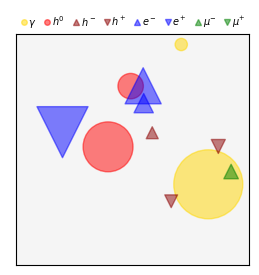

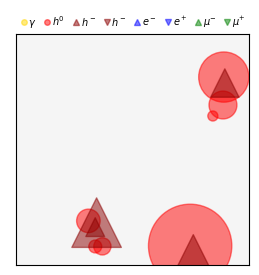

In [ ]:
jets.source.display_cloud(idx=10,  scale_marker=200.0), jets.target.display_cloud(idx=10,  scale_marker=200.0)


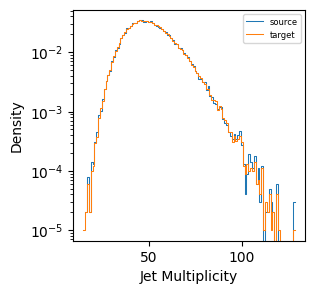

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [ ]:
from cmb.models.trainers import GenerativeDynamicsModule
cfm = GenerativeDynamicsModule(config, jets)
cfm.train()


# Inference

### load trained model

In [1]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/runs/jetclass_generation_CFM_final/GaussNoise_to_JetClass_FlowMatching_EPiC_2024.10.17_20h18_6020/config.yaml'
cfm = GenerativeDynamicsModule(config=path, device='cuda:0')
cfm.load(checkpoint='best')



2024-10-18 18:25:11.373799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 18:25:11.419559: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 18:25:11.420362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 18:25:12.160004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  None
      - solver method:  EulerSolver
INFO: loading `best` epoch checkpoint on cuda:0 from:
  - /home/df630/CMB/results/runs/jetclass_generation_CFM_final/GaussNoise_to_JetClass_FlowMatching_EPiC_2024.10.17_20h18_6020/best_epoch.ckpt


### Generate data

In [2]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.datasets.jetclass import JetDataclass, ParticleClouds

num_jets = 12000
cfm.config.pipeline.num_timesteps=1000
test = JetDataclass(cfm.config.data, task='test', num_jets=num_jets)
test.source.preprocess(output_continuous=cfm.config.data.preprocess.continuous,
                       output_discrete=cfm.config.data.preprocess.discrete,
                       stats=cfm.config.data.source.train.stats.to_dict(),
                       )

cfm.generate(source_continuous=test.source.continuous, 
             mask=test.source.mask,
             dataclass = ParticleClouds,
             output_history=False
             )       

/home/df630/CMB/src/cmb/datasets/utils.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


INFO: generating samples...


batches:   0%|          | 0/12 [00:00<?, ?it/s]

## Plot results

In [9]:
cfm.sample.continuous[...,0].min(), cfm.sample.continuous[...,0].max()

(tensor(-185.8179), tensor(768.5745))

In [11]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures


import torch
import numpy as np
import awkward as ak
import fastjet
import vector
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from dataclasses import dataclass

class JetClassHighLevelFeatures:
    def __init__(self, constituents: ParticleClouds):

        self.constituents = constituents

        #...compute jet kinematics:
        self.constituents.compute_4mom()
        self.px = self.constituents.px.sum(axis=-1)
        self.py = self.constituents.py.sum(axis=-1)
        self.pz = self.constituents.pz.sum(axis=-1)
        self.e = self.constituents.e.sum(axis=-1)
        self.pt = torch.clamp_min(self.px**2 + self.py**2, 0).sqrt()
        self.m = torch.clamp_min(self.e**2 - self.px**2 - self.py**2 - self.pz**2, 0).sqrt()
        self.eta = 0.5 * torch.log((self.pt + self.pz) / (self.pt - self.pz))
        self.phi = torch.atan2(self.py, self.px)

        # discrete jet features
        self.multiplicity = torch.sum(self.constituents.mask, dim=1)
        if hasattr(self.constituents, 'discrete'):
            self.Q_total = self.jet_charge(kappa=0.0)
            self.Q_jet = self.jet_charge(kappa=1.0)

        #...subsstructure
        self.R = 0.8
        self.beta = 1.0
        self.use_wta_scheme = False
        # self.substructure()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        x = getattr(self, features)
        if isinstance(x, torch.Tensor): x.cpu().numpy()
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def jet_charge(self, kappa):
        ''' jet charge defined as Q_j^kappa = Sum_i Q_i * (pT_i / pT_jet)^kappa
        '''
        Qjet = self.constituents.charge.squeeze(-1) * (self.constituents.pt)**kappa
        return Qjet.sum(axis=1) / (self.pt**kappa) 
    
    def histplot_multiplicities(self, state=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        if state is not None:
            if isinstance(state, int):
                state = [state]
            multiplicity = torch.zeros(self.constituents.discrete.shape[0], 1)
            for s in state:
                x = (torch.argmax(self.constituents.discrete, dim=-1).unsqueeze(-1) == s) * self.constituents.mask
                multiplicity += x.sum(dim=1)
        else:
            multiplicity = self.multiplicity

        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=multiplicity.squeeze(-1), element="step", ax=ax, discrete=True, **kwargs) 
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def flavor_fractions(self, figsize=(3,3), ax=None, **kwargs):
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)                                          
        sns.histplot(self.constituents.discrete[self.constituents.mask].squeeze(), binrange=(-0.1, 7.1), element="step", ax=ax, discrete=True, **kwargs)
        ax.legend(loc='upper right', fontsize=7)
        ax.set_xlabel('Particle flavor')
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

    def substructure(self):

        pt_const = torch.clamp_min(self.constituents.pt, 0.0)

        constituents_ak = ak.zip({ "pt": np.array(pt_const),
                                   "eta": np.array(self.constituents.eta_rel),
                                   "phi": np.array(self.constituents.phi_rel),
                                   "mass": np.zeros_like(np.array(self.constituents.pt))
                                   },
                                  with_name="Momentum4D")

        constituents_ak = ak.mask(constituents_ak, constituents_ak.pt > 0)
        constituents_ak = ak.drop_none(constituents_ak)
        self.constituents_ak = constituents_ak[ak.num(constituents_ak) >= 3]
        if self.use_wta_scheme:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R, fastjet.WTA_pt_scheme)
        else:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R)
        print("Clustering jets with fastjet")
        print("Jet definition:", jetdef)
        self.cluster = fastjet.ClusterSequence(constituents_ak, jetdef)
        self.inclusive_jets = self.cluster.inclusive_jets()
        self.exclusive_jets_1 = self.cluster.exclusive_jets(n_jets=1)
        self.exclusive_jets_2 = self.cluster.exclusive_jets(n_jets=2)
        self.exclusive_jets_3 = self.cluster.exclusive_jets(n_jets=3)
        print("Calculating N-subjettiness")
        self._calc_d0()
        self._calc_tau1()
        self._calc_tau2()
        self._calc_tau3()
        self.tau21 = np.ma.divide(self.tau2, self.tau1)
        self.tau32 = np.ma.divide(self.tau3, self.tau2)
        print("Calculating D2")
        # D2 as defined in https://arxiv.org/pdf/1409.6298.pdf
        self.d2 = self.cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

    def _calc_deltaR(self, particles, jet):
        jet = ak.unflatten(ak.flatten(jet), counts=1)
        return particles.deltaR(jet)

    def _calc_d0(self):
        """Calculate the d0 values."""
        self.d0 = ak.sum(self.constituents_ak.pt * self.R**self.beta, axis=1)

    def _calc_tau1(self):
        """Calculate the tau1 values."""
        self.delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_1[:, :1])
        self.pt_i = self.constituents_ak.pt
        self.tau1 = ak.sum(self.pt_i * self.delta_r_1i**self.beta, axis=1) / self.d0

    def _calc_tau2(self):
        """Calculate the tau2 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, 1:2])
        self.pt_i = self.constituents_ak.pt
        # add new axis to make it broadcastable
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau2 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def _calc_tau3(self):
        """Calculate the tau3 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 1:2])
        delta_r_3i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 2:3])
        self.pt_i = self.constituents_ak.pt
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                    delta_r_3i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau3 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def histogram(self, features='pt', density=True, num_bins=100, use_quantiles=False):
        x = getattr(self, features)
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wassertein1D(self, feature, reference):
        x = getattr(self, feature)
        y = getattr(reference, feature)
        return scipy.stats.wasserstein_distance(x, y)









data = JetClassHighLevelFeatures(cfm.sample)
test = JetClassHighLevelFeatures(test.target) 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


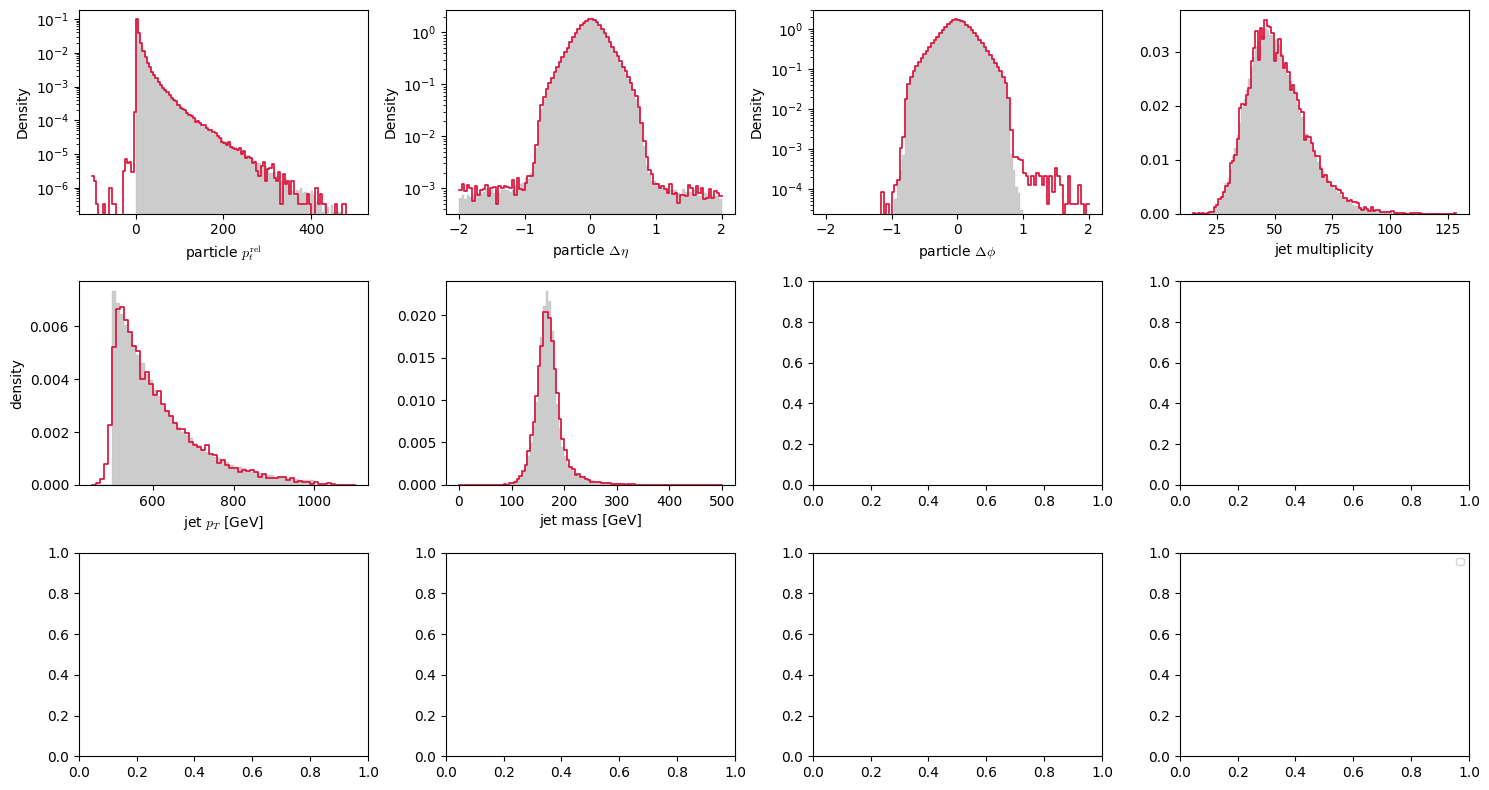

In [13]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(3,4,figsize=(15,8))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='DQ-CFM')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='DQ-CFM')


binrange, binwidth = (-100, 500), 5
data.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_gen_log)
test.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)

binrange, binwidth = (-2, 2), 0.04
data.constituents.histplot('eta_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)
test.constituents.histplot('eta_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)

binrange, binwidth = (-2, 2), 0.04
data.constituents.histplot('phi_rel', binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)
test.constituents.histplot('phi_rel', binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)

data.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)
test.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth = (0, 500), 5
test.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)

# binrange, binwidth, ylim = (0, 1.1), 0.025, (0, 4.0)
# test.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
# data.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)

# test.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_test)
# data.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_gen)

# # ------------------------------

# binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 2.0)
# data.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_gen)
# test.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_test)

plt.legend(fontsize=7)
plt.tight_layout()
plt.savefig(cfm.workdir / f'all_features_{cfm.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()
